# Load libraries and functions and Initialize  

In [1]:
# reload
#%reset
%load_ext autoreload
%autoreload 2 

import warnings
import logging
import os

# DEBUG MODE
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')
logging.getLogger('tensorflow').setLevel(logging.FATAL)
    
from helper_functions import *

# Sets the random seed
# If you want to set a specific seed then pass it as an argument 
initialize(561)
iteration = 'iteration2'
print(torch.cuda.is_available())
print(torch.version.cuda)
pt_type = 'scarf'#['dae', 'vime', 'scarf', 'subtab', 'switchtab']

freeze_encoder = True 

# If True then we are predicting one window ahead if False then we are predicting on the same window 
shift_samp_for_predict = False

Run with random seed:  561
GPU is available.
1
True
12.1


# Set string for saving results and code 

In [2]:
#'sup_singleStep_nextWindow_mlp' 
#'sup_past5Steps_nextWindow_xgb'
notebook_save_str = iteration+'_s3l_unfrozen_'+pt_type

models_folder = 'models/'+pt_type+'_pretrain/'
train_results_filepath = notebook_save_str+'_train_results.csv'
test_results_filepath = notebook_save_str+'_test_results.csv'

# Set Experiment Parameters

In [3]:
#========================================
# Experiment Parameters: Check carefully!
#========================================
time_step_size = '500ms'

# This is where models are saved and loaded from
#dataset_folder = '../../../dataset_ver1/parsed_data_'+time_step_size+'_5steps/' # 500 ms with 5 100ms steps 
dataset_folder = '../../../dataset_ver1/parsed_data_'+time_step_size+'_singleStep/'

pretrain_slice = 'all' #['macro', 'micro', 'slow', 'fast', 'all']
train_slice = 'all' #['macro', 'micro', 'slow', 'fast', 'all', 'only_delay']
test_slice = 'all' #['macro', 'micro', 'slow', 'fast', 'all']

EXP_PARAM = {
    'scaler': 'standard', #'minmax', 'standard', 'robust', 'maxabs', 'l2norm'
    'num_rand_runs': 3 # number of runs with each run doing a different random sample of size label_no from the set of labeled samples 
}


num_samples_list = [100, 1*K, 10*K, 20*K] 
#num_samples_list = [20*K]

#==================================
# Pretraining Experiment Parameters
#==================================

pretrain = False
pretrain_type = 's3l_'+pt_type
pretrain_model_to_save_name = pretrain_slice+'_'+pretrain_type

scaler_to_save_name = pretrain_type+'_'+EXP_PARAM['scaler']+'_scaler'

#==========================================
# Supervised Training Experiment Parameters
#==========================================

# Load an existing pretrained model to use as encoding for sup model 
use_pretrained_model = True
pretrain_model_to_load_type = 's3l_'+pt_type
pretrain_model_to_load_name = pretrain_slice+'_'+pretrain_type
scaler_to_load_name = pretrain_type+'_'+EXP_PARAM['scaler']+'_scaler.pkl'

# Train a sup model with or without using a pretrained model 
sup_model_type = 'mlp' # xgb
suptrain_model_to_save_name = iteration+'_'+train_slice+'_'+pretrain_model_to_load_type+'_'+sup_model_type # could also be sup_model_with_pretrain 


#==================================================
# Experiment Parameters: Not often changed
#==================================================

# When input features are NA 
# Could experiment with forward fill imputation 
# If the label is NA during supervised training then the sample is dropped  
impute_method = 'forward_fill'# ['forward_fill', 'zero_fill']
                              
# These are the ones we have chosen to work with  
#learning_tasks = ['httpClientRtt_trace.txt_page_load_time']
learning_tasks = [#'dashClient_trace.txt_newBitRate_bps', 
                  'vrFragment_trace.txt_vr_frag_thput_mbps', 'vrFragment_trace.txt_vr_burst_thput_mbps',
                  'vrFragment_trace.txt_vr_frag_time', 'vrFragment_trace.txt_vr_burst_time', 
                  #'httpClientRtt_trace.txt_page_load_time',
                  'delay_trace.txt_ul_delay', 'delay_trace.txt_dl_delay']
# index matched with the learning_tasks above
#learning_task_types = ['reg']
learning_task_types = [#'clas', 
                       'reg', 'reg', 
                       'reg', 'reg',
                       #'reg',
                       'reg', 'reg']


# If you want the test samples to be sorted by delay value to see the error differences for the low delay and high delay cases 
sort_test_samples = False

use_all_feats = True
# take the top n features of each run and add it to the top_n_features list  
# If use_all_feats = True then thes will not be used 
feat_filter = 10 
top_n_features = []
# Only valid when use_all_feats = False 
selected_features = []

# All delay values above this will be clipped to the threshold value
clip_outliers = True
delay_clip_th = 5000 # ms

# Set Model Hyperparameters

In [4]:
# Hyperparameters for SSL using DAE 
#print('WARNING !!! HYPERPARAMETERS IN DEBUG MODE')
# Hyperparameters for supervised XGB training 
hypp_sup_xgb={
    'loss':{'reg':'mse',
            'clas':'categorical_crossentropy'}
} 

# Hyperparameters for supervised MLP training
hypp_sup_mlp={
    'fc_layers': [500, 100], # the hidden layers
    'batch_size': 64,  
    'max_epochs': 500,
    'patience': 15,
    'learning_rate': 0.0001,
    'loss':{'reg':'mse',#'mean_absolute_error' 'mean_absolute_percentage_error'
            'clas':'categorical_crossentropy'},
    'metrics':{'reg':['MeanAbsolutePercentageError'],
               'clas':['Recall']},#'F1Score' does nto work needs a different dimension 
    'out_activation':{'reg':'linear', 
                      'clas':'softmax'} 
} 

s3l_sup_mlp={
    'batch_size': 32,
    'max_epochs': 30,
    'patience': 5,
    'loss':{'reg':'MSELoss',
            'clas':'CrossEntropyLoss'},
    'metrics':{'reg':['MeanAbsolutePercentageError'],
               'clas':['Recall']},#'F1Score' does not work needs a different dimension 
}

s3l_hyp_ssl_dae={
    'metric': "mean_absolute_percentage_error",
    'hidden_dim': 500,
    'encoder_depth': 4,
    'head_depth': 2,
    'noise_type': "Swap",
    'noise_ratio': 0.3,
    'max_epochs': 20,
    'batch_size': 128
}

s3l_hyp_ssl_vime={
    'metric': "mean_absolute_percentage_error",
    'hidden_dim': 500,
    'p_m': 0.3, # Corruption probability for self-supervised learning
    'alpha1': 2.0, # Hyper-parameter to control the weights of feature and mask losses
    'alpha2': 2.0, # Hyper-parameter to control the weights of feature and mask losses
    'K': 3, # Number of augmented samples
    'beta': 1.0, # Hyperparameter to control supervised and unsupervised losses
    'max_epochs': 20,
    'batch_size': 128
}

s3l_hyp_ssl_scarf={
    'metric': "mean_absolute_percentage_error",
    'hidden_dim': 500,
    'encoder_depth': 4,
    'head_depth': 2,
    'corruption_rate': 0.6,
    'max_epochs': 20,
    'batch_size': 128,
    'dropout_rate': 0.04
}

s3l_hyp_ssl_subtab={
    'metric': "mean_absolute_percentage_error",
    'hidden_dim': 500,
    'encoder_depth': 4,
    'head_depth': 2,
    'tau': 1.0,
    'use_cosine_similarity': True,
    'use_contrastive': True,
    'use_distance': True,
    'n_subsets': 4,
    'overlap_ratio': 0.75,
    'mask_ratio': 0.1,
    'noise_type': "Swap",
    'noise_level': 0.1,
    'max_epochs': 20,
    'batch_size': 128    
}

s3l_hyp_ssl_switchtab={
    'metric': "mean_absolute_percentage_error",
    'hidden_dim': 500,
    'encoder_depth': 4,
    'n_head': 2,
    'u_label': -1,
    'max_epochs': 20,
    'batch_size': 128    
}

# Hyperparameters for SSL using TabNet
s3l_hyp_ssl_tabnet={
    #'lambda_sparse': , # default = 1e-3
    # This is the extra sparsity loss coefficient as proposed in the original paper. 
    # The bigger this coefficient is, the sparser your model will be in terms of feature selection. 
    # Depending on the difficulty of your problem, reducing this value could help.
    'mask_type': 'entmax', # 'entmax' # default='sparsemax'
    'n_da': 8, # between 8-64 # default=8
    'n_steps': 3, # between 3-10 # default=3
    'n_independent': 2, # between 1-5 # default=2
    'n_shared': 2, # between 1-5 # default=2
    'n_shared_decoder': 1, # default=1
    'n_indep_decoder': 1, # default=1
    'noise_ratio': 0.30,
    'batch_size': 1024, #default=1024
    'max_epochs': 200, # default=200
    'patience': 15 # default=10
}


if sup_model_type == 'mlp':
    sup_hyper_params=hypp_sup_mlp
elif sup_model_type == 'xgb':
    sup_hyper_params=hypp_sup_xgb    


#pretrain_runs = range(1, 10 + 1)
#train_runs = range(11, 17 + 1)
#test_runs = range(18, 20 + 1)

num_pretrain_runs = 10 # 10
num_train_runs = 7 # 7 
num_test_runs = 3 # 3
train_test_run_nums = np.array(range(11, 20+1))
#train_test_run_nums = np.array(range(11, 12+1))


pretrain_runs = range(1, 10 + 1)
#pretrain_runs = range(1, 2 + 1)


# Create the models_folder if it does not already exist
if not os.path.isdir(models_folder):
    os.makedirs(models_folder)

# Load pretraining runs

In [8]:
if pretrain:
    pretrain_data = read_and_concatenate_runs(pretrain_runs, dataset_folder, pretrain_slice, network_info, time_step_size, 
                                              use_all_feats, drop_col_substr, learning_tasks, shift_samp_for_predict, 
                                              impute_method, sum_cols_substr, all_learning_tasks_in_data)

# Pretrain using TabularS3L

In [9]:
# First phase

if pretrain:
    # Remove the labels of all prediction tasks which are also in the datset 
    X_pretrain = pretrain_data.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
    X_pretrain = X_pretrain.dropna()
    X_cols = X_pretrain.columns
    continuous_cols, categorical_cols = get_cont_and_cat_cols(X_pretrain)
    print(X_pretrain.shape)
    # Create, save and use scaler
    val_scaler = create_scaler(X_pretrain, EXP_PARAM['scaler'])
    with open(models_folder + scaler_to_save_name +'.pkl', 'wb') as f:
        pickle.dump(val_scaler, f)
    
    # transform returns a numpy even when you pass a pandas dataframe 
    X_pretrain = val_scaler.transform(X_pretrain).copy()
    X_pretrain = pd.DataFrame(X_pretrain, columns=X_cols)

    assert (pretrain_type in ['s3l_dae', 's3l_vime', 's3l_scarf', 's3l_subtab', 's3l_switchtab'], 
                        f"Invalid pretrain_type: {pretrain_type}.")
    
    if pretrain_type == 's3l_dae':
        pretrain_model, trainer = s3l_pretrain_with_dae(X_pretrain, continuous_cols, categorical_cols, s3l_hyp_ssl_dae, 
                                                    models_folder+pretrain_model_to_save_name)
    elif pretrain_type == 's3l_vime':
        pretrain_model, trainer = s3l_pretrain_with_vime(X_pretrain, continuous_cols, categorical_cols, s3l_hyp_ssl_vime, 
                                                    models_folder+pretrain_model_to_save_name)
    elif pretrain_type == 's3l_scarf':
        pretrain_model, trainer = s3l_pretrain_with_scarf(X_pretrain, continuous_cols, categorical_cols, s3l_hyp_ssl_scarf, 
                                                    models_folder+pretrain_model_to_save_name)
    elif pretrain_type == 's3l_subtab':
        pretrain_model, trainer = s3l_pretrain_with_subtab(X_pretrain, continuous_cols, categorical_cols, s3l_hyp_ssl_subtab, 
                                                    models_folder+pretrain_model_to_save_name)
    elif pretrain_type == 's3l_switchtab':
        pretrain_model, trainer = s3l_pretrain_with_switchtab(X_pretrain, continuous_cols, categorical_cols, s3l_hyp_ssl_switchtab, 
                                                    models_folder+pretrain_model_to_save_name)
        
    # save this pretrained model for later use
    trainer.save_checkpoint(models_folder+pretrain_model_to_save_name+'.ckpt')

# Pretrain using OP libraries

In [26]:
if pretrain:
    # Separate the X and the ys from the data
    # remove the labels of all prediction tasks which are also in the datset 
    X_pretrain = pretrain_data.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
    print(X_pretrain.shape)
  
    val_scaler = create_scaler(X_pretrain, EXP_PARAM['scaler'])
    # Save the scaler for later use when doing supervised training 
    with open(models_folder + scaler_to_save_name +'.pkl', 'wb') as f:
        pickle.dump(val_scaler, f)

    # Use the scaler to scale
    X_pretrain = val_scaler.transform(X_pretrain).copy()
    
    if pretrain_type == 'dae':
        pretrain_model = pretrain_with_dae(pd.DataFrame(X_pretrain))
        # save this pretrained model for later use 
        pretrain_model.save(models_folder+pretrain_model_to_save_name)
    elif pretrain_type == 'tabnet':
        X_pretrain, X_pretrain_val = train_test_split(X_pretrain, test_size=0.2, shuffle=True) 
        pretrain_model = pretrain_with_tabnet(pd.DataFrame(X_pretrain),  pd.DataFrame(X_pretrain_val))
        pretrain_model.save_model(models_folder+pretrain_model_to_save_name)
        # show the results of feature importance
        tabnet_explain(pretrain_model, X_pretrain_val)
    elif pretrain_type == 'vime':
        # Train VIME-Self
        vime_self_parameters = dict()
        vime_self_parameters['batch_size'] = hyp_ssl_semi_vime['batch_size']
        vime_self_parameters['epochs'] = hyp_ssl_semi_vime['epochs'] 
        vime_self_encoder = vime_self(X_pretrain, hyp_ssl_semi_vime['p_m'], hyp_ssl_semi_vime['alpha'], vime_self_parameters)  
        # Save encoder
        vime_self_encoder.save(models_folder+pretrain_model_to_save_name+'.h5')

# Load Tabnet pretrained model for explainability results

In [22]:
# Load a pretrained model for getting explainability results
# Load the pretrained model and scaler 
#with open(models_folder + scaler_to_load_name + '.pkl', 'rb') as f:
#    val_scaler = pickle.load(f)
#
#
## remove the labels of all prediction tasks which are also in the datset 
#X_pretrain_val = test_data.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
#print(X_pretrain_val.shape)
#
## Fill with 0 the values that are missing in the input features so that the sample can still be used
#X_pretrain_val = impute_data(X_pretrain_val, impute_method, sum_cols_substr)
#
#X_pretrain_val = val_scaler.transform(X_pretrain_val).copy()
# 
#if pretrain_model_to_load_type == 'tabnet':
#    pretrain_model = TabNetPretrainer()
#    pretrain_model.load_model(models_folder+pretrain_model_to_load_name)
#    X_pretrain_val = pretrain_model.predict(X_pretrain_val)[0]
#    tabnet_explain(pretrain_model, X_pretrain_val)
#else:
#    print('Do not have explainability functionality for this model type')

# Iterate over num. labeled samples
# Iterate over different random initializations  
# Iterate over learning_tasks

# Pre-process data 
# Train model
# Evaluate model


NUM. LABELLED SAMPLES:  100
Random iteration:  0
# train runs used  7
# test runs used  3
Concatenating runs:  [15 18 16 13 17 14 11]
Time to read csv file for run:  3.078974962234497
Loaded run 15
Time to read csv file for run:  2.9067697525024414
Loaded run 18
Time to read csv file for run:  2.8802714347839355
Loaded run 16
Time to read csv file for run:  2.7780134677886963
Loaded run 13
Time to read csv file for run:  2.8773553371429443
Loaded run 17
Time to read csv file for run:  2.860759973526001
Loaded run 14
Time to read csv file for run:  2.8697574138641357
Loaded run 11
Concatenating runs:  [12 19 20]
Time to read csv file for run:  2.8850390911102295
Loaded run 12
Time to read csv file for run:  2.9021685123443604
Loaded run 19
Time to read csv file for run:  3.4243667125701904
Loaded run 20
Time to read data:  79.40376448631287
Learning task:  vrFragment_trace.txt_vr_frag_thput_mbps task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no g

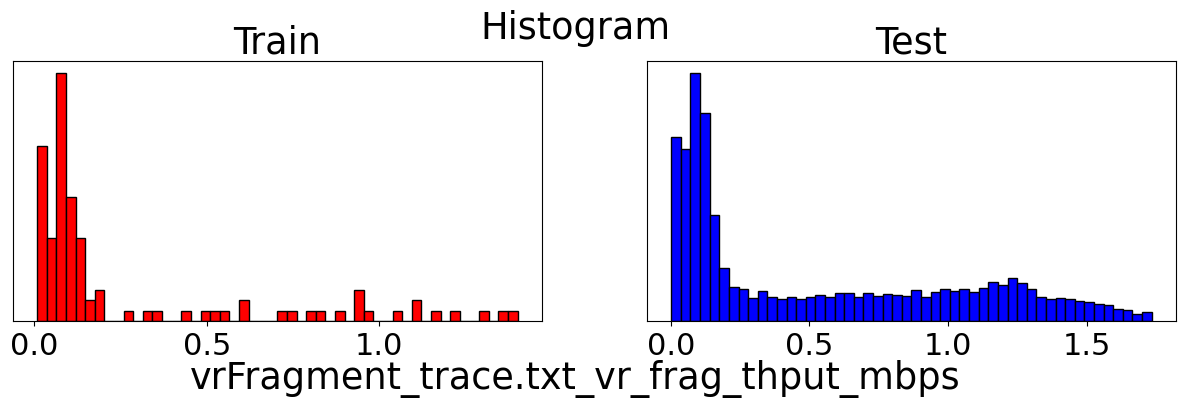

Seed set to 42


Time to process data for one learning task:  0.935542106628418


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


   | Name                                   | Type        | Params | Mode 
--------------------------------------------------------------------------------
0  | task_loss_fn                           | MSELoss     | 0      | train
1  | contrastive_loss                       | NTXentLoss  | 0      | train
2  | model                                  | SCARF       | 1.6 M  | train
3  | model._SCARF__encoder                  | MLP         | 809 K  | train
4  | model._SCARF__encoder.linear_0         | Linear      | 54.5 K | train
5  | model._SCARF__encoder.batchnorm_0      | BatchNorm1d | 1.0 K  | train
6  | model._SCARF__encoder.relu_0           | ReLU        | 0      | train
7  | model._SCARF__encoder.dropout_0        | Dropout     | 0      | train
8  | model._SCARF__encoder.linear_1         | Linear      | 250 K  | train
9  | model._SCARF__encoder.batchnorm_1      | BatchNorm1d | 1.0 K  | train
10 | model._SCARF__encoder.relu_1           | ReLU        | 0      | train
11 | model._SCARF__

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | task_loss_fn     | MSELoss    | 0      | train
1 | contrastive_loss | NTXentLoss | 0      | train
2 | model            | SCARF      | 1.6 M  | train
--------------------------------------------------------
802 K     Trainable params
809 K     Non-trainable params
1.6 M     Total params
6.447     Total estimated model params size (MB)


Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s, v_num=2, train_loss=0.0753, train_mean_absolute_percentage_error=3.200, val_mean_absolute_percentage_error=4.750, val_loss=0.365]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                   | Type        | Params | Mode 
--------------------------------------------------------------------------------
0  | task_loss_fn                           | MSELoss     | 0      | train
1  | contrastive_loss                       | NTXentLoss  | 0      | train
2  | model                                  | SCARF       | 1.6 M  | train
3  | model._SCARF__encoder                  | MLP         | 809 K  | train
4  | model._SCARF__encoder.linear_0         | Linear      | 54.5 K | train
5  | model._SCARF__encoder.batchnorm_0      | BatchNorm1d | 1.0 K  | train
6  | model._SCARF__encoder.relu_0           | ReLU        | 0      | train
7  | model._SCARF__encoder.dropout_0        | Dropout     | 0      | train
8  | model._SCARF__encoder.linear_1         | Linear      | 250 K  | train
9  | model._SCARF__encoder.batchnorm_1      | BatchNorm1d | 1.0 K  | train
10 | model._SCARF__encoder.relu_1           | ReLU        | 0      | train
11 | model._SCARF__

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s]NOTE: Clipping the predictions to be within the range of the ground-truth values


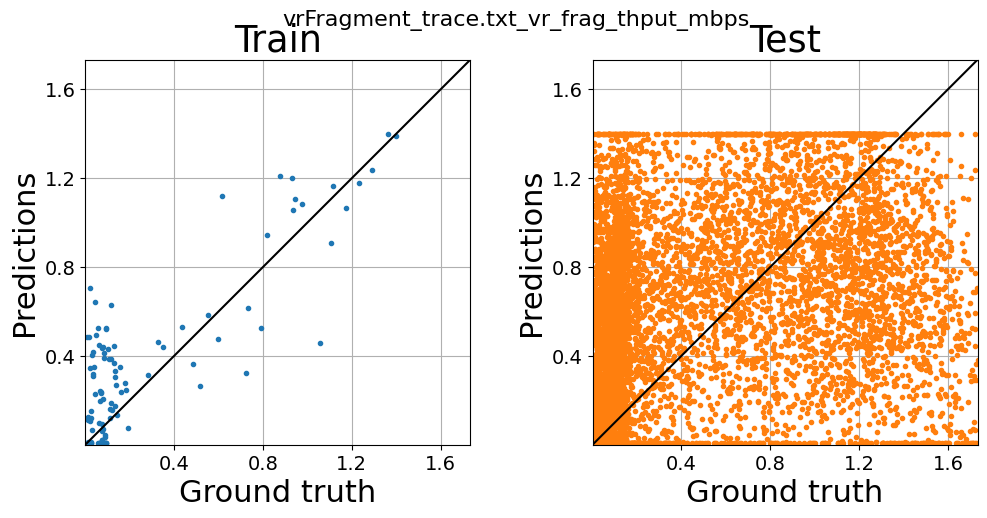



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_thput_mbps task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(23113, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [17406  1632  1469  1558   804]
After removing bins that are not populated enough
[0 1 2 3 4] [17406  1632  1469  1558   804]
(22869, 108)
(22869,)
(22869,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(9838, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [5012 1047 1327 1569  765]
After removing bins that are not populated enough
[0 1 2 3 

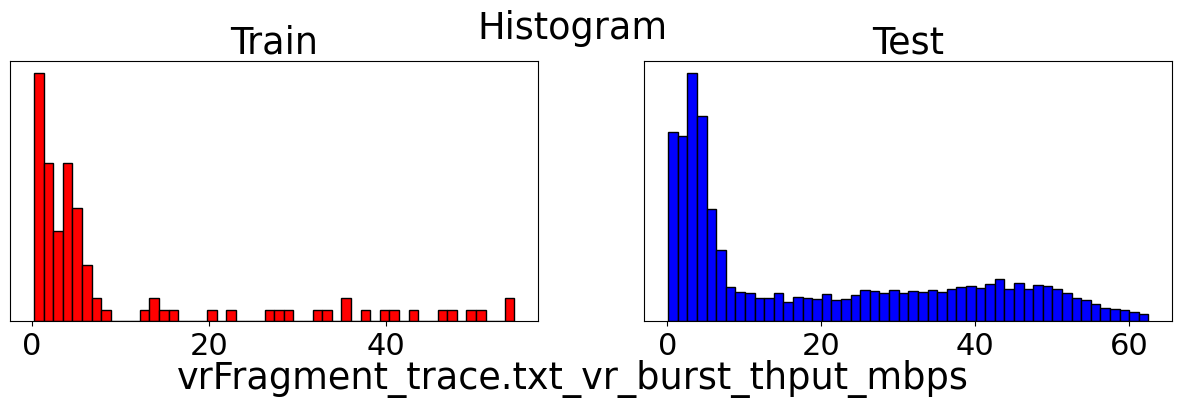

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | task_loss_fn     | MSELoss    | 0      | train
1 | contrastive_loss | NTXentLoss | 0      | train
2 | model            | SCARF      | 1.6 M  | train
--------------------------------------------------------
802 K     Trainable params
809 K     Non-trainable params
1.6 M     Total params
6.447     Total estimated model params size (MB)


Time to process data for one learning task:  0.45740675926208496
   | Name                                   | Type        | Params | Mode 
--------------------------------------------------------------------------------
0  | task_loss_fn                           | MSELoss     | 0      | train
1  | contrastive_loss                       | NTXentLoss  | 0      | train
2  | model                                  | SCARF       | 1.6 M  | train
3  | model._SCARF__encoder                  | MLP         | 809 K  | train
4  | model._SCARF__encoder.linear_0         | Linear      | 54.5 K | train
5  | model._SCARF__encoder.batchnorm_0      | BatchNorm1d | 1.0 K  | train
6  | model._SCARF__encoder.relu_0           | ReLU        | 0      | train
7  | model._SCARF__encoder.dropout_0        | Dropout     | 0      | train
8  | model._SCARF__encoder.linear_1         | Linear      | 250 K  | train
9  | model._SCARF__encoder.batchnorm_1      | BatchNorm1d | 1.0 K  | train
10 | model._SCARF__encoder.re

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                   | Type        | Params | Mode 
--------------------------------------------------------------------------------
0  | task_loss_fn                           | MSELoss     | 0      | train
1  | contrastive_loss                       | NTXentLoss  | 0      | train
2  | model                                  | SCARF       | 1.6 M  | train
3  | model._SCARF__encoder                  | MLP         | 809 K  | train
4  | model._SCARF__encoder.linear_0         | Linear      | 54.5 K | train
5  | model._SCARF__encoder.batchnorm_0      | BatchNorm1d | 1.0 K  | train
6  | model._SCARF__encoder.relu_0           | ReLU        | 0      | train
7  | model._SCARF__encoder.dropout_0        | Dropout     | 0      | train
8  | model._SCARF__encoder.linear_1         | Linear      | 250 K  | train
9  | model._SCARF__encoder.batchnorm_1      | BatchNorm1d | 1.0 K  | train
10 | model._SCARF__encoder.relu_1           | ReLU        | 0      | train
11 | model._SCARF__

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s]NOTE: Clipping the predictions to be within the range of the ground-truth values


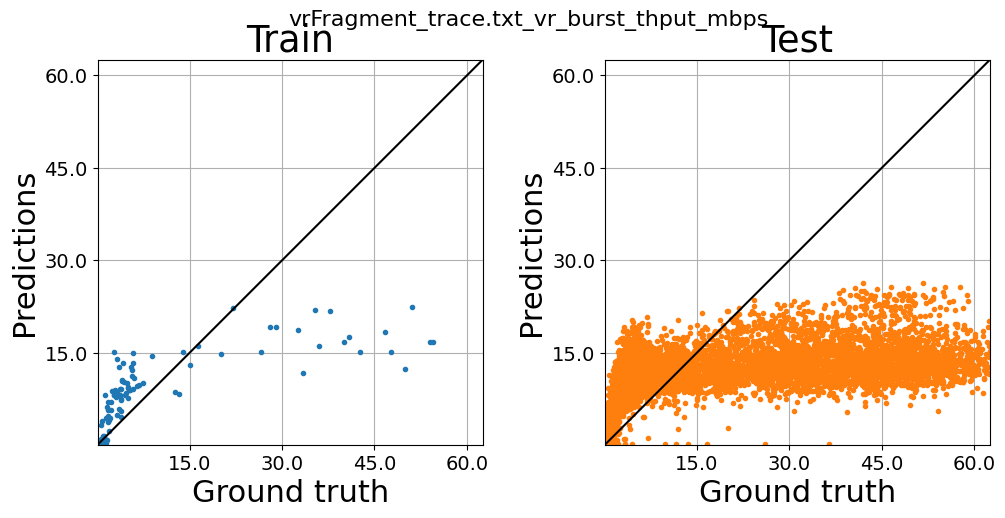



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_time task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(23124, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [17590  3246  1264   535   243]
After removing bins that are not populated enough
[0 1 2 3 4] [17590  3246  1264   535   243]
(22878, 108)
(22878,)
(22878,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(9862, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [8719  628  223  111   63]
After removing bins that are not populated enough
[0 1 2 3 4] [871

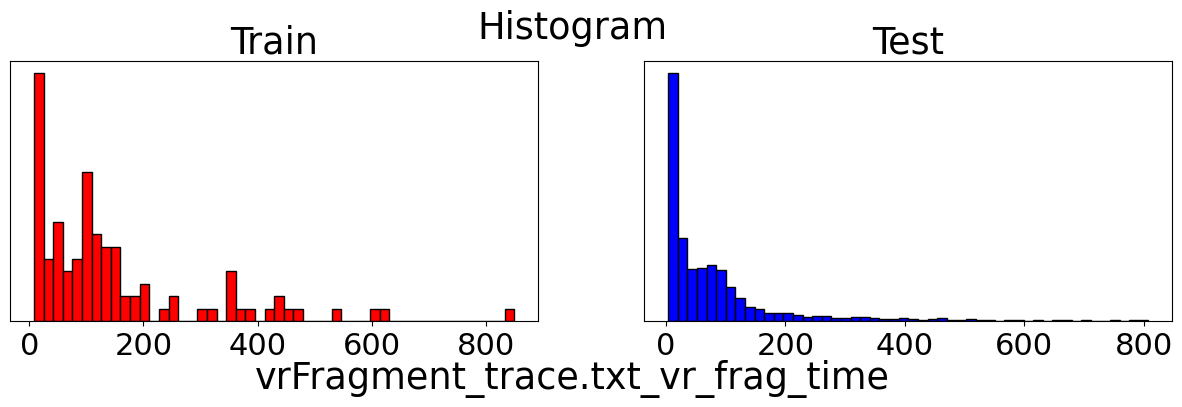

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | task_loss_fn     | MSELoss    | 0      | train
1 | contrastive_loss | NTXentLoss | 0      | train
2 | model            | SCARF      | 1.6 M  | train
--------------------------------------------------------
802 K     Trainable params
809 K     Non-trainable params
1.6 M     Total params
6.447     Total estimated model params size (MB)


Time to process data for one learning task:  0.7096693515777588
   | Name                                   | Type        | Params | Mode 
--------------------------------------------------------------------------------
0  | task_loss_fn                           | MSELoss     | 0      | train
1  | contrastive_loss                       | NTXentLoss  | 0      | train
2  | model                                  | SCARF       | 1.6 M  | train
3  | model._SCARF__encoder                  | MLP         | 809 K  | train
4  | model._SCARF__encoder.linear_0         | Linear      | 54.5 K | train
5  | model._SCARF__encoder.batchnorm_0      | BatchNorm1d | 1.0 K  | train
6  | model._SCARF__encoder.relu_0           | ReLU        | 0      | train
7  | model._SCARF__encoder.dropout_0        | Dropout     | 0      | train
8  | model._SCARF__encoder.linear_1         | Linear      | 250 K  | train
9  | model._SCARF__encoder.batchnorm_1      | BatchNorm1d | 1.0 K  | train
10 | model._SCARF__encoder.rel

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.64it/s, v_num=4, train_loss=1.62e+4, train_mean_absolute_percentage_error=2.130, val_mean_absolute_percentage_error=3.880, val_loss=1.18e+4]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                   | Type        | Params | Mode 
--------------------------------------------------------------------------------
0  | task_loss_fn                           | MSELoss     | 0      | train
1  | contrastive_loss                       | NTXentLoss  | 0      | train
2  | model                                  | SCARF       | 1.6 M  | train
3  | model._SCARF__encoder                  | MLP         | 809 K  | train
4  | model._SCARF__encoder.linear_0         | Linear      | 54.5 K | train
5  | model._SCARF__encoder.batchnorm_0      | BatchNorm1d | 1.0 K  | train
6  | model._SCARF__encoder.relu_0           | ReLU        | 0      | train
7  | model._SCARF__encoder.dropout_0        | Dropout     | 0      | train
8  | model._SCARF__encoder.linear_1         | Linear      | 250 K  | train
9  | model._SCARF__encoder.batchnorm_1      | BatchNorm1d | 1.0 K  | train
10 | model._SCARF__encoder.relu_1           | ReLU        | 0      | train
11 | model._SCARF__

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s]NOTE: Clipping the predictions to be within the range of the ground-truth values


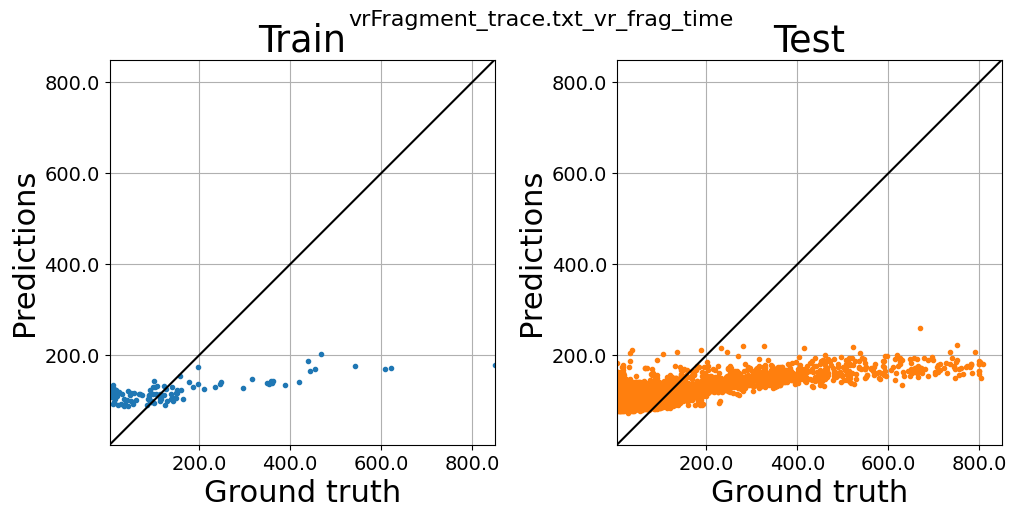



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_time task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(23113, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [17523  3259  1275   560   252]
After removing bins that are not populated enough
[0 1 2 3 4] [17523  3259  1275   560   252]
(22869, 108)
(22869,)
(22869,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(9838, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [8694  623  237  105   61]
After removing bins that are not populated enough
[0 1 2 3 4] [86

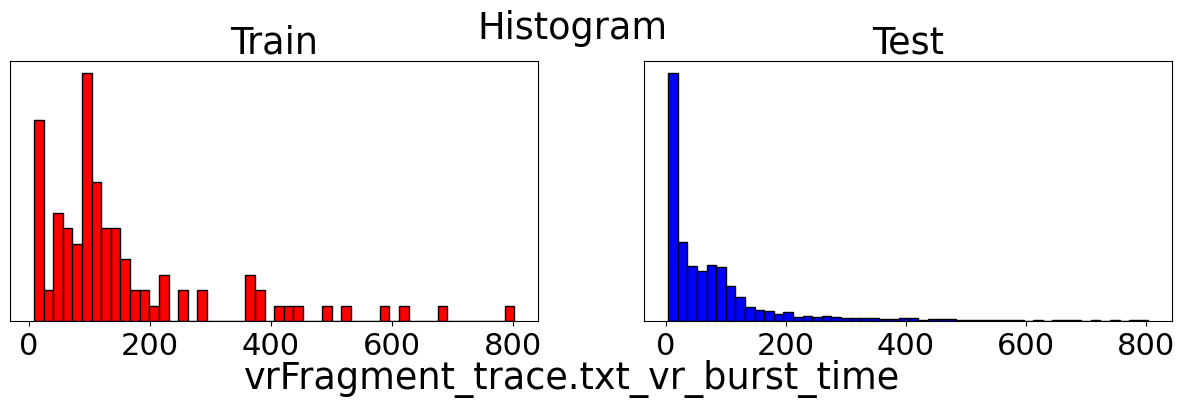

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | task_loss_fn     | MSELoss    | 0      | train
1 | contrastive_loss | NTXentLoss | 0      | train
2 | model            | SCARF      | 1.6 M  | train
--------------------------------------------------------
802 K     Trainable params
809 K     Non-trainable params
1.6 M     Total params
6.447     Total estimated model params size (MB)


Time to process data for one learning task:  0.48354077339172363
   | Name                                   | Type        | Params | Mode 
--------------------------------------------------------------------------------
0  | task_loss_fn                           | MSELoss     | 0      | train
1  | contrastive_loss                       | NTXentLoss  | 0      | train
2  | model                                  | SCARF       | 1.6 M  | train
3  | model._SCARF__encoder                  | MLP         | 809 K  | train
4  | model._SCARF__encoder.linear_0         | Linear      | 54.5 K | train
5  | model._SCARF__encoder.batchnorm_0      | BatchNorm1d | 1.0 K  | train
6  | model._SCARF__encoder.relu_0           | ReLU        | 0      | train
7  | model._SCARF__encoder.dropout_0        | Dropout     | 0      | train
8  | model._SCARF__encoder.linear_1         | Linear      | 250 K  | train
9  | model._SCARF__encoder.batchnorm_1      | BatchNorm1d | 1.0 K  | train
10 | model._SCARF__encoder.re

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa0029d39d0>
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
[rank: 0] Received SIGTERM: 15
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Exception ignored in: <function _after_fork at 0x7fa1acab5940>

   | Name                                   | Type        | Params | Mode 
--------------------------------------------------------------------------------
0  | task_loss_fn                           | MSELoss     | 0      | train
1  | contrastive_loss                       | NTXentLoss  | 0      | train
2  | model                                  | SCARF       | 1.6 M  | train
3  | model._SCARF__encoder                  | MLP         | 809 K  | train
4  | model._SCARF__encoder.linear_0         | Linear      | 54.5 K | train
5  | model._SCARF__encoder.batchnorm_0      | BatchNorm1d | 1.0 K  | train
6  | model._SCARF__encoder.relu_0           | ReLU        | 0      | train
7  | model._SCARF__encoder.dropout_0        | Dropout     | 0      | train
8  | model._SCARF__encoder.linear_1         | Linear      | 250 K  | train
9  | model._SCARF__encoder.batchnorm_1      | BatchNorm1d | 1.0 K  | train
10 | model._SCARF__encoder.relu_1           | ReLU        | 0      | train
11 | model._SCARF__


  File "/usr/lib/python3.8/threading.py", line 1457, in _after_fork
Traceback (most recent call last):
    thread._stop()
  File "/usr/lib/python3.8/threading.py", line 964, in _stop

    self._is_stopped = TrueKeyboardInterrupt: 


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s]NOTE: Clipping the predictions to be within the range of the ground-truth values


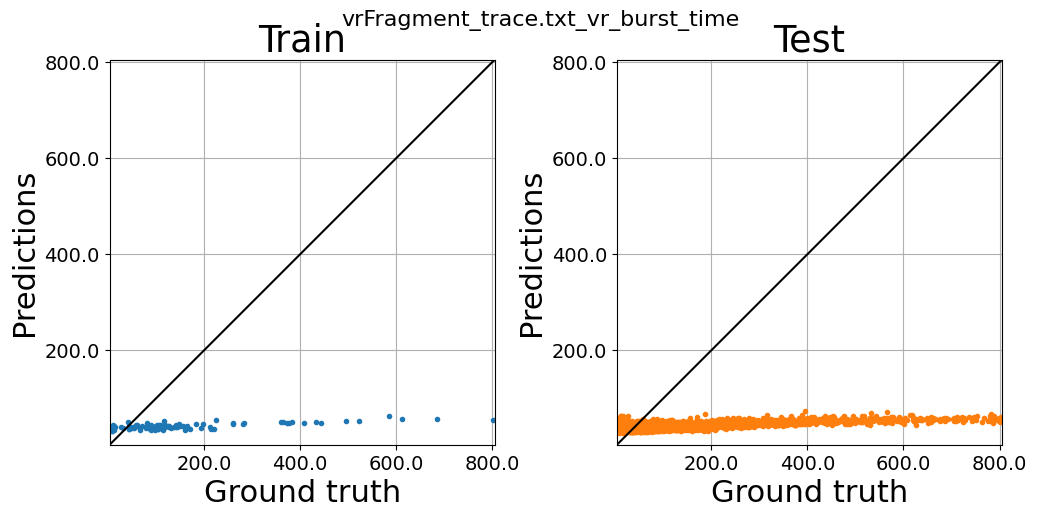



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_ul_delay task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(1186946, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [1164740    4810    2469    1726    1329]
After removing bins that are not populated enough
[0 1 2 3 4] [1164740    4810    2469    1726    1329]
(1164740, 108)
(1164740,)
(1164740,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(509618, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not p

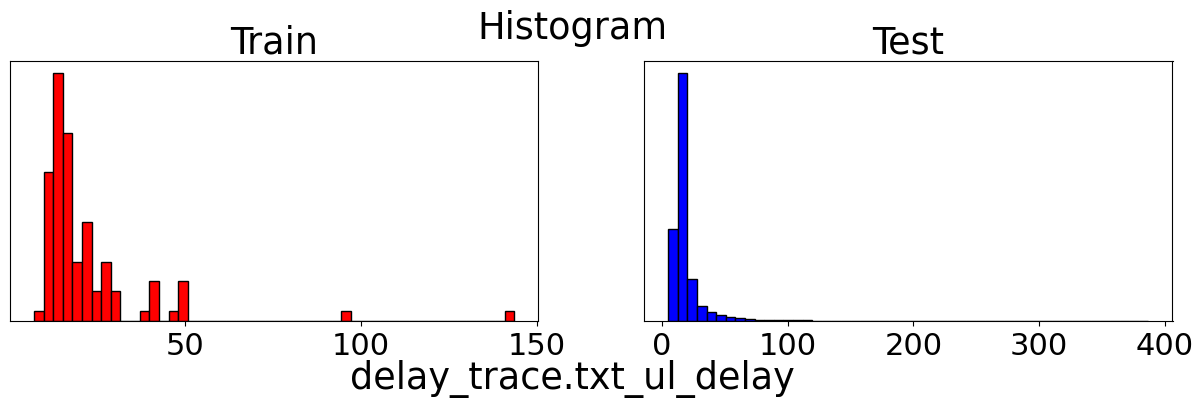

Time to process data for one learning task:  8.223292589187622


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | task_loss_fn     | MSELoss    | 0      | train
1 | contrastive_loss | NTXentLoss | 0      | train
2 | model            | SCARF      | 1.6 M  | train
--------------------------------------------------------
802 K     Trainable params
809 K     Non-trainable params
1.6 M     Total params
6.447     Total estimated model params size (MB)


   | Name                                   | Type        | Params | Mode 
--------------------------------------------------------------------------------
0  | task_loss_fn                           | MSELoss     | 0      | train
1  | contrastive_loss                       | NTXentLoss  | 0      | train
2  | model                                  | SCARF       | 1.6 M  | train
3  | model._SCARF__encoder                  | MLP         | 809 K  | train
4  | model._SCARF__encoder.linear_0         | Linear      | 54.5 K | train
5  | model._SCARF__encoder.batchnorm_0      | BatchNorm1d | 1.0 K  | train
6  | model._SCARF__encoder.relu_0           | ReLU        | 0      | train
7  | model._SCARF__encoder.dropout_0        | Dropout     | 0      | train
8  | model._SCARF__encoder.linear_1         | Linear      | 250 K  | train
9  | model._SCARF__encoder.batchnorm_1      | BatchNorm1d | 1.0 K  | train
10 | model._SCARF__encoder.relu_1           | ReLU        | 0      | train
11 | model._SCARF__

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                   | Type        | Params | Mode
-------------------------------------------------------------------------------
0  | task_loss_fn                           | MSELoss     | 0      | eval
1  | contrastive_loss                       | NTXentLoss  | 0      | eval
2  | model                                  | SCARF       | 1.6 M  | eval
3  | model._SCARF__encoder                  | MLP         | 809 K  | eval
4  | model._SCARF__encoder.linear_0         | Linear      | 54.5 K | eval
5  | model._SCARF__encoder.batchnorm_0      | BatchNorm1d | 1.0 K  | eval
6  | model._SCARF__encoder.relu_0           | ReLU        | 0      | eval
7  | model._SCARF__encoder.dropout_0        | Dropout     | 0      | eval
8  | model._SCARF__encoder.linear_1         | Linear      | 250 K  | eval
9  | model._SCARF__encoder.batchnorm_1      | BatchNorm1d | 1.0 K  | eval
10 | model._SCARF__encoder.relu_1           | ReLU        | 0      | eval
11 | model._SCARF__encoder.dropo

Exception ignored in: <function _releaseLock at 0x7fa1aadd3c10>
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s]


KeyboardInterrupt



In [5]:
# Erase the contents of the results file into which we append as we loop through 
open(train_results_filepath, 'w').close()
open(test_results_filepath, 'w').close()

# Iterate over different number of labeled samples 
for label_no in num_samples_list:
    
    EXP_PARAM['label_no'] = label_no

    # Aggregate results over runs
    train_results = pd.DataFrame(index=learning_tasks, columns=['MAE', 'MAPE', 'R2']) # or ['ACC', 'F1', 'ROC_AUC']
    test_results = pd.DataFrame(index=learning_tasks, columns=['MAE', 'MAPE', 'R2']) # or ['ACC', 'F1', 'ROC_AUC']
    # Apply the function to each cell in the DataFrame
    train_results = train_results.applymap(lambda x: create_nan_array(EXP_PARAM['num_rand_runs']))
    test_results = test_results.applymap(lambda x: create_nan_array(EXP_PARAM['num_rand_runs']))

    # Iterate over different random initializations
    for rs in range(0, EXP_PARAM['num_rand_runs']):
        read_data_start_time = time.time()
        print('==========================================================================')
        print('NUM. LABELLED SAMPLES: ', label_no)
        print('==========================================================================')
        print('==========================================================================')
        print('Random iteration: ', rs)
        print('==========================================================================')
                    
        # Randomly select which runs shall be train and which shall be test 
        shuffled_run_ind = np.random.permutation(len(train_test_run_nums))
        train_runs = train_test_run_nums[shuffled_run_ind[:num_train_runs]]
        test_runs = train_test_run_nums[shuffled_run_ind[num_train_runs:]]
        print('# train runs used ', len(train_runs))
        print('# test runs used ', len(test_runs))
        
        # Read the runs from files and creater a train and test dataset 
        train_data = read_and_concatenate_runs (train_runs, dataset_folder, train_slice, network_info, time_step_size, 
                                               use_all_feats, drop_col_substr, learning_tasks, shift_samp_for_predict, 
                                               impute_method, sum_cols_substr, all_learning_tasks_in_data)
        test_data = read_and_concatenate_runs (test_runs, dataset_folder, test_slice, network_info, time_step_size, 
                                              use_all_feats, drop_col_substr, learning_tasks, shift_samp_for_predict, 
                                              impute_method, sum_cols_substr, all_learning_tasks_in_data)
        print('Time to read data: ', time.time() - read_data_start_time)
        for idx, learning_task in enumerate(learning_tasks):
            
            task_it_start_time = time.time()
            print('================================================================================')
            print('Learning task: ', learning_task, 'task type: ', learning_task_types[idx] )
            print('================================================================================')
    
            learning_task_type = learning_task_types[idx]
            is_regression = learning_task_type == 'reg'
            learning_task_type_ff = 'regression'
            if learning_task_type == 'clas':
                learning_task_type_ff = 'classification'

            X_train, y_train, train_strat_array, X_feats, continuous_cols, categorical_cols = make_data_sup_model_ready (train_data, learning_task, learning_task_type,
                                                                                     all_learning_tasks_in_data, bitrate_levels, 
                                                                                     clip_outliers, delay_clip_th)
            X_test, y_test, test_strat_array, _ , _, _= make_data_sup_model_ready (test_data, learning_task, learning_task_type, 
                                                             all_learning_tasks_in_data, bitrate_levels, 
                                                             clip_outliers, delay_clip_th)
            
            # Sample a subset of the train samples to be equal to the num of labelled samples we need
            sample_size = EXP_PARAM['label_no']
            if len(y_train) <= EXP_PARAM['label_no']:
                print("\n\nWARNING !!!!\n\nAsked to sample from train set of size "+str(len(y_train))+ 
                      " a number greater than or equal to its size "+str(EXP_PARAM['label_no']))
                print('Going to just take as many samples as available, No need to random sample')
            else:
                # This functions helps me random sample with stratification 
                X_train, _, y_train, _ = train_test_split(X_train, y_train,
                                                                      train_size=EXP_PARAM['label_no'], shuffle=True,
                                                                      stratify=train_strat_array)
                
            # create a validation set from the test set 
            X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                          test_size=0.25, shuffle=True, 
                                                          stratify=test_strat_array)  
            
            print('Train data shape ' + str(X_train.shape))
            print('Test data shape ' + str(X_test.shape))
            print('Val data shape ' + str(X_val.shape))
    
            plot_hist_of_y(y_train, y_test, learning_task)
             
            print('Time to process data for one learning task: ', time.time() - task_it_start_time)
            
            #=============================================== Train and test the model ==================================
        
            start_time = time.time()
    
            if use_pretrained_model:
                
                assert (pretrain_model_to_load_type in ['s3l_dae', 's3l_vime', 's3l_scarf', 's3l_subtab', 's3l_switchtab'], 
                        f"Invalid pretrain_model_to_load_type: {pretrain_model_to_load_type}.")
                # get the latent representations from pretrained model
                # Load the pretrained model and scaler 
                # Load the saved MinMaxScaler object from the file
                with open(models_folder + scaler_to_load_name, 'rb') as f:
                    val_scaler = pickle.load(f)

                X_train = val_scaler.transform(X_train).copy()
                X_test = val_scaler.transform(X_test).copy()
                X_val = val_scaler.transform(X_val).copy()
                # transform returns numpy. I need to convert back to pandas dataframe
                X_train = pd.DataFrame(X_train, columns=X_feats)
                X_val = pd.DataFrame(X_val, columns=X_feats)
                X_test = pd.DataFrame(X_test, columns=X_feats)
                
                # load the model
                model = s3l_load(models_folder+pretrain_model_to_load_name+'.ckpt', pretrain_model_to_load_type)
                # model is of type class 'ts3l.pl_modules.dae_lightning.DAELightning'
                print(ModelSummary(model, max_depth=-1))
                # set model to second phase
                model.set_second_phase(freeze_encoder=freeze_encoder)
                # prepare a trainer 
                early_stopping = EarlyStopping(monitor='val_loss', patience=s3l_sup_mlp['patience'], verbose=False, mode='min')
                model_checkpoint = ModelCheckpoint(
                    monitor='val_loss',   # Metric to monitor
                    save_top_k=1,         # Save only the best model
                    mode='min',           # Mode should be 'min' for metrics that should decrease
                    filename=notebook_save_str+'_{epoch}-{val_loss:.2f}',  # Format of saved files
                    save_last=True        # Save the last model
                )
                # Mode should be 'min' for metrics that should decrease
                sup_trainer = Trainer(accelerator = 'gpu', 
                                          max_epochs = s3l_sup_mlp['max_epochs'], 
                                          num_sanity_val_steps = 2, 
                                          callbacks=[MyProgressBar(), early_stopping, model_checkpoint], 
                                          #callbacks=[MyProgressBar()], 
                                          default_root_dir=models_folder+suptrain_model_to_save_name)
                # Need to reset DAE config for every learning task 




                if pretrain_model_to_load_type == 's3l_dae':
 
                    train_ds = DAEDataset(X = X_train, Y = y_train, is_regression=is_regression,
                                          continuous_cols=continuous_cols, category_cols=categorical_cols)
                    valid_ds = DAEDataset(X = X_val, Y = y_val, is_regression=is_regression,
                                          continuous_cols=continuous_cols, category_cols=categorical_cols)
                    datamodule = TS3LDataModule(train_ds, valid_ds, is_regression=is_regression,
                                                batch_size = s3l_sup_mlp['batch_size'], train_sampler="random")
                    
                    sup_trainer.fit(model, datamodule)
                    print(ModelSummary(model, max_depth=-1))
                    # Load the best model 
                    #best_model_path = model_checkpoint.best_model_path
                    #print(f"Best model path: {best_model_path}")
                    #model = DAELightning.load_from_checkpoint(best_model_path)
                    
                    # Evaluation
                    test_ds = DAEDataset(X_test, category_cols=categorical_cols, 
                                         continuous_cols=continuous_cols, is_regression=is_regression)
                    test_dl = DataLoader(test_ds, s3l_sup_mlp['batch_size'], 
                                         shuffle=False, sampler = SequentialSampler(test_ds), num_workers=4)
                    train_ds = DAEDataset(X_train, continuous_cols=continuous_cols, 
                                          category_cols=categorical_cols, is_regression=is_regression)
                    train_dl = DataLoader(train_ds, s3l_sup_mlp['batch_size'], 
                                         shuffle=False, sampler = SequentialSampler(train_ds), num_workers=4)
                
                elif pretrain_model_to_load_type == 's3l_vime':
                    
                    train_ds = VIMEDataset(X = X_train, Y = y_train, is_regression=is_regression,
                                           continuous_cols=continuous_cols, category_cols=categorical_cols, 
                                           is_second_phase=True)
                    valid_ds = VIMEDataset(X = X_val, Y = y_val, is_regression=is_regression,
                                           continuous_cols=continuous_cols, category_cols=categorical_cols, 
                                           is_second_phase=True)
                            
                    datamodule = TS3LDataModule(train_ds, valid_ds, batch_size = s3l_sup_mlp['batch_size'], is_regression=is_regression,
                                                train_sampler="random", train_collate_fn=VIMESecondPhaseCollateFN())
                    
                    sup_trainer.fit(model, datamodule)
                    print(ModelSummary(model, max_depth=-1))
                    # Load the best model 
                    #best_model_path = model_checkpoint.best_model_path
                    #print(f"Best model path: {best_model_path}")
                    #model = VIMELightning.load_from_checkpoint(best_model_path)

                    # Evaluation
                    test_ds = VIMEDataset(X_test, category_cols=categorical_cols, is_regression=is_regression,
                                         continuous_cols=continuous_cols, is_second_phase=True)
                    test_dl = DataLoader(test_ds, s3l_sup_mlp['batch_size'], 
                                         shuffle=False, sampler = SequentialSampler(test_ds), num_workers=4)
                    train_ds = VIMEDataset(X_train, continuous_cols=continuous_cols, is_regression=is_regression, 
                                          category_cols=categorical_cols, is_second_phase=True)
                    train_dl = DataLoader(train_ds, s3l_sup_mlp['batch_size'], 
                                         shuffle=False, sampler = SequentialSampler(train_ds), num_workers=4)

                elif pretrain_model_to_load_type == 's3l_scarf':

                    
                    train_ds = SCARFDataset(X_train, y_train, is_regression=is_regression, is_second_phase=True)
                    valid_ds = SCARFDataset(X_val, y_val, is_regression=is_regression, is_second_phase=True)
                    
                    datamodule = TS3LDataModule(train_ds, valid_ds, batch_size = s3l_sup_mlp['batch_size'], is_regression=is_regression, 
                                                train_sampler="random")
                    
                    sup_trainer.fit(model, datamodule)
                    print(ModelSummary(model, max_depth=-1))
                    # Load the best model 
                    #best_model_path = model_checkpoint.best_model_path
                    #print(f"Best model path: {best_model_path}")
                    #model = SCARFLightning.load_from_checkpoint(best_model_path)

                    # Evaluation
                    test_ds = SCARFDataset(X_test, is_regression=is_regression, is_second_phase=True)
                    test_dl = DataLoader(test_ds, s3l_sup_mlp['batch_size'], 
                                         shuffle=False, sampler = SequentialSampler(test_ds), num_workers=4)
                    train_ds = SCARFDataset(X_train, is_regression=is_regression, is_second_phase=True)
                    train_dl = DataLoader(train_ds, s3l_sup_mlp['batch_size'], 
                                         shuffle=False, sampler = SequentialSampler(train_ds), num_workers=4)

                elif pretrain_model_to_load_type == 's3l_subtab':
                    
                    # Only subtab seems to demand that config be passed into it again, so doing it here 
                    
                    config = SubTabConfig( task="regression", loss_fn="MSELoss", metric=s3l_hyp_ssl_subtab['metric'], metric_hparams={}, 
                                          input_dim=X_train.shape[1], hidden_dim=s3l_hyp_ssl_subtab['hidden_dim'], output_dim=1, 
                                          tau=s3l_hyp_ssl_subtab['tau'], use_cosine_similarity=s3l_hyp_ssl_subtab['use_cosine_similarity'], 
                                          use_contrastive=s3l_hyp_ssl_subtab['use_contrastive'], use_distance=s3l_hyp_ssl_subtab['use_distance'], 
                                          n_subsets=s3l_hyp_ssl_subtab['n_subsets'], overlap_ratio=s3l_hyp_ssl_subtab['overlap_ratio'], 
                                          mask_ratio=s3l_hyp_ssl_subtab['mask_ratio'], noise_type=s3l_hyp_ssl_subtab['noise_type'], 
                                          noise_level=s3l_hyp_ssl_subtab['noise_level'])
                    
                    train_ds = SubTabDataset(X_train, y_train, is_regression=is_regression)
                    valid_ds = SubTabDataset(X_val, y_val, is_regression=is_regression)
                    
                    datamodule = TS3LDataModule(train_ds, valid_ds, batch_size = s3l_sup_mlp['batch_size'], is_regression=is_regression, 
                                                train_sampler="random", train_collate_fn=SubTabCollateFN(config), 
                                                valid_collate_fn=SubTabCollateFN(config))
                    #datamodule = TS3LDataModule(train_ds, valid_ds, batch_size = s3l_sup_mlp['batch_size'], is_regression=is_regression, 
                    #                            train_sampler="random")
                    
                    sup_trainer.fit(model, datamodule)
                    print(ModelSummary(model, max_depth=-1))
                    # Load the best model 
                    #best_model_path = model_checkpoint.best_model_path
                    #print(f"Best model path: {best_model_path}")
                    #model = SubTabLightning.load_from_checkpoint(best_model_path)

                    # Evaluation
                    test_ds = SubTabDataset(X_test, is_regression=is_regression)
                    test_dl = DataLoader(test_ds, s3l_sup_mlp['batch_size'], collate_fn=SubTabCollateFN(config),
                                         shuffle=False, sampler = SequentialSampler(test_ds), num_workers=4)
                    train_ds = SubTabDataset(X_train, is_regression=is_regression)
                    train_dl = DataLoader(train_ds, s3l_sup_mlp['batch_size'], collate_fn=SubTabCollateFN(config),
                                         shuffle=False, sampler = SequentialSampler(train_ds), num_workers=4)

                elif pretrain_model_to_load_type == 's3l_switchtab':
                 
                    train_ds = SwitchTabDataset(X_train, y_train, continuous_cols=continuous_cols, category_cols=categorical_cols, 
                                                is_regression=is_regression, is_second_phase=True)
                    valid_ds = SwitchTabDataset(X_val, y_val, continuous_cols=continuous_cols, category_cols=categorical_cols, 
                                                is_regression=is_regression, is_second_phase=True)
                    
                    datamodule = TS3LDataModule(train_ds, valid_ds, batch_size = s3l_sup_mlp['batch_size'], is_regression=is_regression, 
                                                train_sampler="random")
                    
                    sup_trainer.fit(model, datamodule)
                    print(ModelSummary(model, max_depth=-1))
                    # Load the best model 
                    #best_model_path = model_checkpoint.best_model_path
                    #print(f"Best model path: {best_model_path}")
                    #model = SwitchTabLightning.load_from_checkpoint(best_model_path)

                    # Evaluation
                    test_ds = SwitchTabDataset(X_test, continuous_cols=continuous_cols, category_cols=category_cols, 
                                               is_regression=is_regression, is_second_phase=True)
                    test_dl = DataLoader(test_ds, s3l_sup_mlp['batch_size'], 
                                         shuffle=False, sampler = SequentialSampler(test_ds), num_workers=4)
                    train_ds = SwitchTabDataset(X_train, continuous_cols=continuous_cols, category_cols=category_cols, 
                                                is_regression=is_regression, is_second_phase=True)
                    train_dl = DataLoader(train_ds, s3l_sup_mlp['batch_size'], 
                                         shuffle=False, sampler = SequentialSampler(train_ds), num_workers=4)




                    
                if learning_task_type == 'reg':
                    yhat_test = sup_trainer.predict(model, test_dl)
                    yhat_test = torch.concat([out.cpu() for out in yhat_test]).squeeze()
                    yhat_train = sup_trainer.predict(model, train_dl)
                    yhat_train = torch.concat([out.cpu() for out in yhat_train]).squeeze()
                    #print(y_train)
                    #print(yhat_train)
                    # Clip predictions to the range of the training data
                    print('NOTE: Clipping the predictions to be within the range of the ground-truth values')
                    yhat_train = np.clip(yhat_train, y_train.min(), y_train.max())
                    yhat_test = np.clip(yhat_test, y_train.min(), y_train.max())
                    #print(yhat_train)
                     
                else: #'clas'
                    yhat_train_a = sup_trainer.predict(model, train_dl)
                    yhat_train_proba = F.softmax(torch.concat([out.cpu() for out in yhat_train_a]).squeeze(),dim=1)
                    yhat_train = yhat_train_proba.argmax(1)
                    yhat_test_a = sup_trainer.predict(model, test_dl)
                    yhat_test_proba = F.softmax(torch.concat([out.cpu() for out in yhat_test_a]).squeeze(),dim=1)
                    yhat_test = yhat_test_proba.argmax(1)
                    print(y_train)
                    print(yhat_train)
                    print(yhat_train_proba)        
            #accuracy = accuracy_score(y_test, yhat_test_proba.argmax(1))
                
            else: # only supervised training 
                val_scaler = create_scaler(X_train, EXP_PARAM['scaler'])
                # save the scaler model to a file
                with open(models_folder + scaler_to_save_name + '.pkl', 'wb') as f:
                    pickle.dump(val_scaler, f)
                
                X_train = val_scaler.transform(X_train).copy()
                X_test = val_scaler.transform(X_test).copy()
                X_val = val_scaler.transform(X_val).copy()
                # Need to train the model
                # Train and save the model       
                model, history = train_model(X_train, X_val, 
                                            y_train, y_val, 
                                            sup_model_type, learning_task_type,
                                            models_folder + suptrain_model_to_save_name,
                                            sup_hyper_params)
                if learning_task_type == 'reg':
                    yhat_test = model.predict(X_test).flatten()
                    yhat_train = model.predict(X_train).flatten()
                    # Clip predictions to the range of the training data
                    print('NOTE: Clipping the predictions to be within the range of the ground-truth values')
                    yhat_train = np.clip(yhat_train, y_train.min(), y_train.max())
                    yhat_test = np.clip(yhat_test, y_train.min(), y_train.max())
                    
                else: #learning_task_type == 'clas':
                    if sup_model_type == 'xgb':
                        yhat_test = model.predict(X_test).flatten()
                        yhat_train = model.predict(X_train).flatten()
                        yhat_test_proba = model.predict_proba(X_test)
                        yhat_train_proba = model.predict_proba(X_train)
                    else:
                        yhat_test = np.argmax(model.predict(X_test), axis=1)
                        yhat_train = np.argmax(model.predict(X_train), axis=1)
                        yhat_test_proba = model.predict(X_test)
                        yhat_train_proba = model.predict(X_train)
                        
            
                end_time = time.time()
                print('Time to train model: ', end_time - start_time)
                if not use_pretrained_model:
                    # Feature importance
                    if ((sup_model_type == 'tabnet') or (sup_model_type == 'xgb')):
                        plot_feature_importance(model.feature_importances_, X_feats, feat_filter)
            
            #====================================
            # Predict using the supervised model 
            #====================================
            
            if learning_task_type == 'reg':
                if np.isnan(yhat_train).any():
                    print('WARNING: nans in the predicted train vals')
                    print(yhat_train)
                train_results.loc[learning_task, 'MAE'][rs] = compute_error(y_train, yhat_train, 'mae')
                train_results.loc[learning_task, 'MAPE'][rs] = compute_error(y_train, yhat_train, 'mape')
                train_results.loc[learning_task, 'R2'][rs] = compute_error(y_train, yhat_train, 'r2')
                # Compute and Print Test set errors
                if np.isnan(yhat_test).any():
                    print('WARNING: NaNs in the predicted test vals')
                    print(yhat_test)
                test_results.loc[learning_task, 'MAE'][rs] = compute_error(y_test, yhat_test, 'mae')
                test_results.loc[learning_task, 'MAPE'][rs] = compute_error(y_test, yhat_test, 'mape')
                test_results.loc[learning_task, 'R2'][rs] = compute_error(y_test, yhat_test, 'r2')

                # Predicted versus ground-truth plots
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
                fig.suptitle(learning_task, fontsize=16)
                y = np.concatenate((y_train, y_test))
                yhat = np.concatenate((yhat_train, yhat_test))
                bounds=[min( min(y),min(yhat) ), max( max(y),max(yhat) )]        
                # Configure each subplot
                setup_axes(axes[0], y_train, yhat_train, 'Train', COLOUR_HEX[0], bounds)  # Adjust color as needed
                setup_axes(axes[1], y_test, yhat_test, 'Test', COLOUR_HEX[1], bounds)  # Adjust color as needed
                #plt.tight_layout()
                plt.show()
            else: # clas
                if np.isnan(yhat_train).any():
                    print('WARNING: nans in the predicted train vals')
                    print(yhat_train)                
                
                train_results.loc[learning_task, 'MAE'][rs] = compute_error(y_train, yhat_train, 'acc')
                train_results.loc[learning_task, 'MAPE'][rs] = compute_error(y_train, yhat_train, 'f1score')
                train_results.loc[learning_task, 'R2'][rs] = compute_error(y_train, yhat_train_proba, 'roc_auc')
            
                # Compute and Print Test set errors
                if np.isnan(yhat_test).any():
                    print('WARNING: NaNs in the predicted test vals')
                    print(yhat_test)
                test_results.loc[learning_task, 'MAE'][rs] = compute_error(y_test, yhat_test, 'acc')
                test_results.loc[learning_task, 'MAPE'][rs] = compute_error(y_test, yhat_test, 'f1score')
                test_results.loc[learning_task, 'R2'][rs] = compute_error(y_test, yhat_test_proba, 'roc_auc')
                
                # Confusion matrix plots
                draw_confusion_matrix(y_train, yhat_train, 'Train: Confusion Matrix')
                draw_confusion_matrix(y_test, yhat_test, 'Test: Confusion Matrix')
           
            print('')
            print('')
            print('===============================  DONE  ===================================================')
            
    print('============================= Train set mean over runs ===================================')
    mean_train_results = train_results.applymap(mean_array)
    print(mean_train_results)
    print('=============================== Test set results =========================================')
    print(test_results.applymap(format_array))
    print('============================= Test set mean over runs ====================================')
    mean_test_results = test_results.applymap(mean_array)
    print(test_results.applymap(mean_array))
    print('==========================================================================================')
    # Add number of samples as a column
    mean_train_results.insert(0, 'num_samples', EXP_PARAM['label_no'])
    mean_test_results.insert(0, 'num_samples', EXP_PARAM['label_no'])
    # Append to file
    mean_train_results.to_csv(train_results_filepath, mode='a', header=False)    
    mean_test_results.to_csv(test_results_filepath, mode='a', header=False)
    

# Save the notebook and save the results in the model folder 

In [ ]:
os.system('cp ts3l_train_and_eval.ipynb '+models_folder+notebook_save_str+'.ipynb')
os.system('cp '+train_results_filepath+' '+models_folder+'.')
os.system('cp '+test_results_filepath+' '+models_folder+'.')